# Roche Limit for the moon

We know the Roche Limit (the location  of  the  tidal  radius) for  two  bodies is given by the formula  $d = 2.46 \times R (ρ_M/ρ_m)^{1/3}$ where $ρ_M$ is the density of the primary  body, $ρ_m$  is  the  density  of  the  satellite,  and  $R$  is  the  radius  of  the  main  body. This is the formula for the case when the satellite is in hydrostatic equilibrium. \\
We will assume the moon has density of Earth and the planet Laligurans has density of Jupiter. \\
Density of Earth = $5520 kg/m^3$ and Density of Jupiter = $1,326 kg/m^3$. So, 
$ρ_M = 1326 kg/m^3$ and $ρ_m = 5520 kg/m^3$. And radius of Laligurans is taken as radius of Jupiter $R = 69,911 km = 6.9911 \times 10^7 m $ \\
Roche limit for the Laligurans-exomoon system is


In [23]:
Rochem = 2.46*6.9911e7*(1326/5520)**(1/3)
print("Roche limit for the moon is %.3f metres" % Rochem)
Roche = Rochem/1.496e11 #*1.23
print("Roche limit for the moon is %.6f Astronomical Units (AU)" % Roche)

Roche limit for the moon is 106909287.904 metres
Roche limit for the moon is 0.000715 Astronomical Units (AU)


In [24]:
Rochem = 2.46*6.9911e7*(1326/3340)**(1/3)
print("Roche limit for the moon is %.3f metres" % Rochem)
Roche = Rochem/1.496e11 #*1.23
print("Roche limit for the moon is %.6f Astronomical Units (AU)" % Roche)

Roche limit for the moon is 126399776.822 metres
Roche limit for the moon is 0.000845 Astronomical Units (AU)


In [19]:
M_p = 1.16 * 1.898e27
M_s = 1.989e30
M_m = 5.972e24 
M_m = 7.34e22 
a_p = 1.03
e_p = 0.36
Hillradius = a_p * (1-e_p) * ((M_p+M_m)/(3*M_s))**(1/3) 
Hillradius

0.04728115509443171

# Stability map with MEGNO using WHFAST and IAS15
In this tutorial, we'll create a stability map of a two planet system using the chaos indicator MEGNO (Mean Exponential Growth of Nearby Orbits) and two different integrators, IAS15 and WHFAST. 

We will integrate a two planet system with massive planets. We vary two orbital parameters, the semi-major axis $a$ and the eccentricity $e$. Let us first define a function that runs one simulation for a given set of initial conditions $(a, e)$.

In [ ]:
def ias_simulation(par):
    am, em = par # unpack parameters for moon
    
    sim=rebound.Simulation()
    
    sim.units=['Yr2pi', 'AU', 'Msun']
    sim.add(m=1,hash="Sagarmatha")                #Sun-mass star
    sim.add(m=0.0009543,a=1,e=0.36,hash="Laligurans")   #Jupiter-mass planet
    sim.add(m=0.000003003,a=am,e=em,primary=sim.particles["Laligurans"]) #Earth-mass moon around Laligurans
    sim.move_to_com()
    
    sim.init_megno()
    sim.exit_max_distance = 20.
    try:
        sim.integrate(1000*2*np.pi) 
        megno = sim.calculate_megno() 
        return megno
    except rebound.Escape:
        return 10. # At least one particle got ejected, returning large MEGNO.

In [ ]:
def whfast_simulation(par):
    am, em = par # unpack parameters
    
    sim = rebound.Simulation()
    sim.integrator = "whfast"
    sim.ri_whfast.safe_mode = 0
    sim.dt = 0.0015/40
    sim.units=['Yr2pi', 'AU', 'Msun']
    sim.add(m=1,hash="Sagarmatha")                #Sun-mass star
    sim.add(m=0.0009543,a=1,e=0.36,hash="Laligurans")   #Jupiter-mass planet
    sim.add(m=0.000003003,a=am,e=em,primary=sim.particles["Laligurans"]) #Earth-mass moon around Laligurans
    sim.move_to_com()
    
    sim.init_megno()
    sim.exit_max_distance = 20.
    try:
        sim.integrate(1000*2.*np.pi, exact_finish_time=0) # integrate to the nearest timestep for each output
        #to keep the timestep constant and preserve WHFast's symplectic nature
        megno = sim.calculate_megno() 
        return megno
    except rebound.Escape:
        return 10. # At least one particle got ejected, returning large MEGNO.

Let's try this out and run one simulation

In [ ]:
!pip install rebound


     |████████████████████████████████| 245kB 2.8MB/s 
  Created wheel for rebound: filename=rebound-3.12.1-cp36-cp36m-linux_x86_64.whl size=561456 sha256=5c954861ee80905e79dafc848d5a03c51b04b402639b2b6ae4b32d8944a2777a
  Stored in directory: /root/.cache/pip/wheels/60/66/12/82f1787c138e1b997ddef3a80481d189c4e7d36cf7e89d2839
Successfully built rebound


In [ ]:
import numpy as np
import time
import rebound
import csv

In [ ]:
t1=time.time()
val_megno=ias_simulation((0.002569,0.1)) 
t2=time.time()
print("Timer",t2-t1)
print(val_megno)

Timer 1.9102418422698975
2.003022314187565


In [ ]:
t1=time.time()
val_megno=whfast_simulation((0.002569,0.1)) 
t2=time.time()
print("Timer",t2-t1)
print(val_megno)

Timer 1.1461751461029053
2.0013908182053575


The return value is the MEGNO. It is about 2, thus the system is regular for these initial conditions. Let's run a whole array of simulations.

## MEGNO MAP USING IAS15

In [ ]:
Ngrid = 2
results_ias = np.zeros(Ngrid*Ngrid)
par_a = np.linspace(0.01,0.04,Ngrid)
par_e = np.linspace(0.,0.4,Ngrid)
parameters = []
for e in par_e:
    for a in par_a:
        parameters.append((a,e))

with open('megno_record_ias.csv', mode='w') as megno_record:
  megno_recorder = csv.writer(megno_record, delimiter=',')
  for i,item in enumerate(parameters):
    t1=time.time()

    print("Running simulation for",item)
    val_megno = ias_simulation(item)
    t2=time.time()
    print(val_megno)
    results_ias[i] = val_megno
    megno_recorder.writerow([parameters[i][0],parameters[i][1],val_megno])
    print("Timer:",(t2-t1))

Running simulation for (0.01, 0.0)
1.9322031800097044
Timer: 0.19051194190979004
Running simulation for (0.04, 0.0)
3.7765057333037046
Timer: 0.016081809997558594
Running simulation for (0.01, 0.4)
2.0026101473010467
Timer: 0.4067416191101074
Running simulation for (0.04, 0.4)


In [ ]:
#parameters
results_ias, parameters

(array([ 2.06890703, 10.        ,  2.16250287, 10.        ]),
 [(0.3, 0.0), (0.5, 0.0), (0.3, 0.4), (0.5, 0.4)])

In [ ]:
parameters[0][1]

0.0

Let's plot it!

In [ ]:
results2d_ias = np.array(results_ias).reshape(Ngrid,Ngrid)
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(111)
extent = [min(par_a),max(par_a),min(par_e),max(par_e)]
ax.set_xlim(extent[0],extent[1])
ax.set_xlabel("semi-major axis $a$")
ax.set_ylim(extent[2],extent[3])
ax.set_ylabel("eccentricity $e$")
im = ax.imshow(results2d_ias, interpolation="none", vmin=1.9, vmax=4, cmap="RdYlGn_r", origin="lower", aspect='auto', extent=extent)
cb = plt.colorbar(im, ax=ax)
cb.set_label("MEGNO $\\langle Y \\rangle$")
plt.xticks(par_a)
plt.yticks(par_e)

plt.title("Megno map for the system using IAS15 integrator")
plt.savefig("megno_ias15.pdf")

In [ ]:
0.002569

0.002569

## MEGNO MAP USING WHFAST

In [ ]:
Ngrid = 10
par_a = np.linspace(0.3,0.6,Ngrid)
par_e = np.linspace(0.,0.3,Ngrid)
parameters = []
for e in par_e:
    for a in par_a:
        parameters.append((a,e))
from rebound.interruptible_pool import InterruptiblePool
pool = InterruptiblePool()
t1=time.time()
results = pool.map(whfast_simulation,parameters)
t2=time.time()
print("Timer:",(t2-t1))

Timer: 71.6913206577301


In [ ]:
parameters, results

([(0.3, 0.0), (0.6, 0.0), (0.3, 0.3), (0.6, 0.3)],
 [1.9452289238517775, 10.0, 2.078397134455917, 10.0])

In [ ]:
with open('megno_record_whfast.csv', mode='w') as megno_record:
  megno_recorder = csv.writer(megno_record, delimiter=',')
  for i in range(len(results)):
    megno_recorder.writerow([parameters[i][0],parameters[i][1],results[i]])


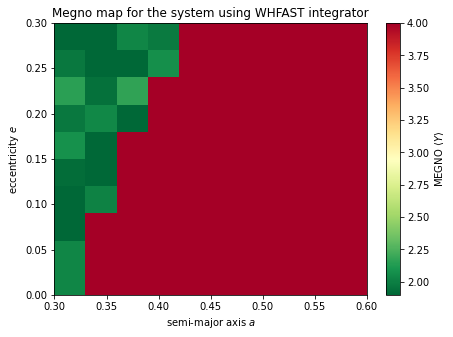

In [ ]:
results2d = np.array(results).reshape(Ngrid,Ngrid)
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(111)
extent = [min(par_a),max(par_a),min(par_e),max(par_e)]
ax.set_xlim(extent[0],extent[1])
ax.set_xlabel("semi-major axis $a$")
ax.set_ylim(extent[2],extent[3])
ax.set_ylabel("eccentricity $e$")
im = ax.imshow(results2d, interpolation="none", vmin=1.9, vmax=4, cmap="RdYlGn_r", origin="lower", aspect='auto', extent=extent)
cb = plt.colorbar(im, ax=ax)
cb.set_label("MEGNO $\\langle Y \\rangle$")

plt.title("Megno map for the system using WHFAST integrator")
plt.savefig("megno_whfast.pdf")

### MEGNO MAP USING MERCURIUS

Megno not implemented for Mercurius integrator